In [24]:
#Clair3 guided backpropagation and input tensor feature maps visualization demo
# install and import the necessary packages
%matplotlib inline
import numpy as np
import argparse
import time
import numpy as np
import subprocess
import sys
import tables
import os
import numpy as np
import cv2
import importlib
import pandas as pd
import random
import subprocess
import os
import sys
import tables
import importlib

import tensorflow as tf
import tensorflow.keras as keras

from matplotlib import font_manager as fm
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from  matplotlib import cm

current_path = os.getcwd()
sys.path.append(os.path.join(current_path, 'Clair3'))
sys.path.append(os.path.join(current_path, '..', '..', 'Clair3'))
import shared.param_f as param
from clair3.model_GP import Clair3_F

#disable cuda for computation
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
#parameters
platform = 'ont'
tensor_shape = param.ont_input_shape if platform == 'ont' else param.input_shape
input_tensor_shape = tuple([None] + tensor_shape)
label_shape = param.label_shape
#replace with your model path accordingly 
full_alignment_model_path = os.path.join(current_path, 'models', 'r941_prom_sup_g5014', 'full_alignment')

#get input tensor
## follow https://github.com/HKU-BAL/Clair3/blob/feature_visualization/docs/feature_visualization.md to 
## generate input tensor accordingly
input_tensor = os.path.join(current_path, "input_matrix.npy")


In [3]:
# build Clair3 full-alignment model in graph mode
class FocalLoss(tf.keras.losses.Loss):
    """
    updated version of focal loss function, for multi class classification, we remove alpha parameter, which the loss
    more stable, and add gradient clipping to avoid gradient explosion and precision overflow.
    """

    def __init__(self, label_shape_cum, task, effective_label_num=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.cls_weights = None
        if effective_label_num is not None:
            task_label_num = get_label_task(effective_label_num, label_shape_cum, task)
            cls_weights = cal_class_weight(task_label_num, len(task_label_num))
            cls_weights = tf.constant(cls_weights, dtype=tf.float32)
            cls_weights = tf.expand_dims(cls_weights, axis=0)
            self.cls_weights = cls_weights

    def call(self, y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, clip_value_min=1e-9, clip_value_max=1 - 1e-9)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = ((1 - y_pred) ** self.gamma) * y_true
        FCLoss = cross_entropy * weight
        if self.cls_weights is not None:
            FCLoss = FCLoss * self.cls_weights
        reduce_fl = tf.reduce_sum(FCLoss, axis=-1)
        return reduce_fl

m = Clair3_F(add_indel_length=True, predict=True)

m.build(input_shape=input_tensor_shape)

m.load_weights(full_alignment_model_path)
task_num = 4
m.build(input_shape=input_tensor_shape)
loss_func = [FocalLoss(label_shape, task, None) for task in range(task_num)]
loss_task = {"output_{}".format(task + 1): loss_func[task] for task in range(task_num)}
m.compile(
    loss=loss_task,
    optimizer='adam'
)
network = keras.Sequential([
    m
])

network.build(input_shape=input_tensor_shape)

tmp_matrix = np.ones(shape = [10] + tensor_shape)
prediction = m.predict_on_batch(tmp_matrix)
output = m(tmp_matrix)


2022-11-01 11:39:53.916661: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-01 11:39:53.916764: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: bal33
2022-11-01 11:39:53.916784: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: bal33
2022-11-01 11:39:53.918265: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 418.67.0
2022-11-01 11:39:53.918347: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 418.67.0
2022-11-01 11:39:53.918366: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 418.67.0
2022-11-01 11:39:53.921036: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perfor

[INFO] Visualize guided backpropagation feature maps of SNP position


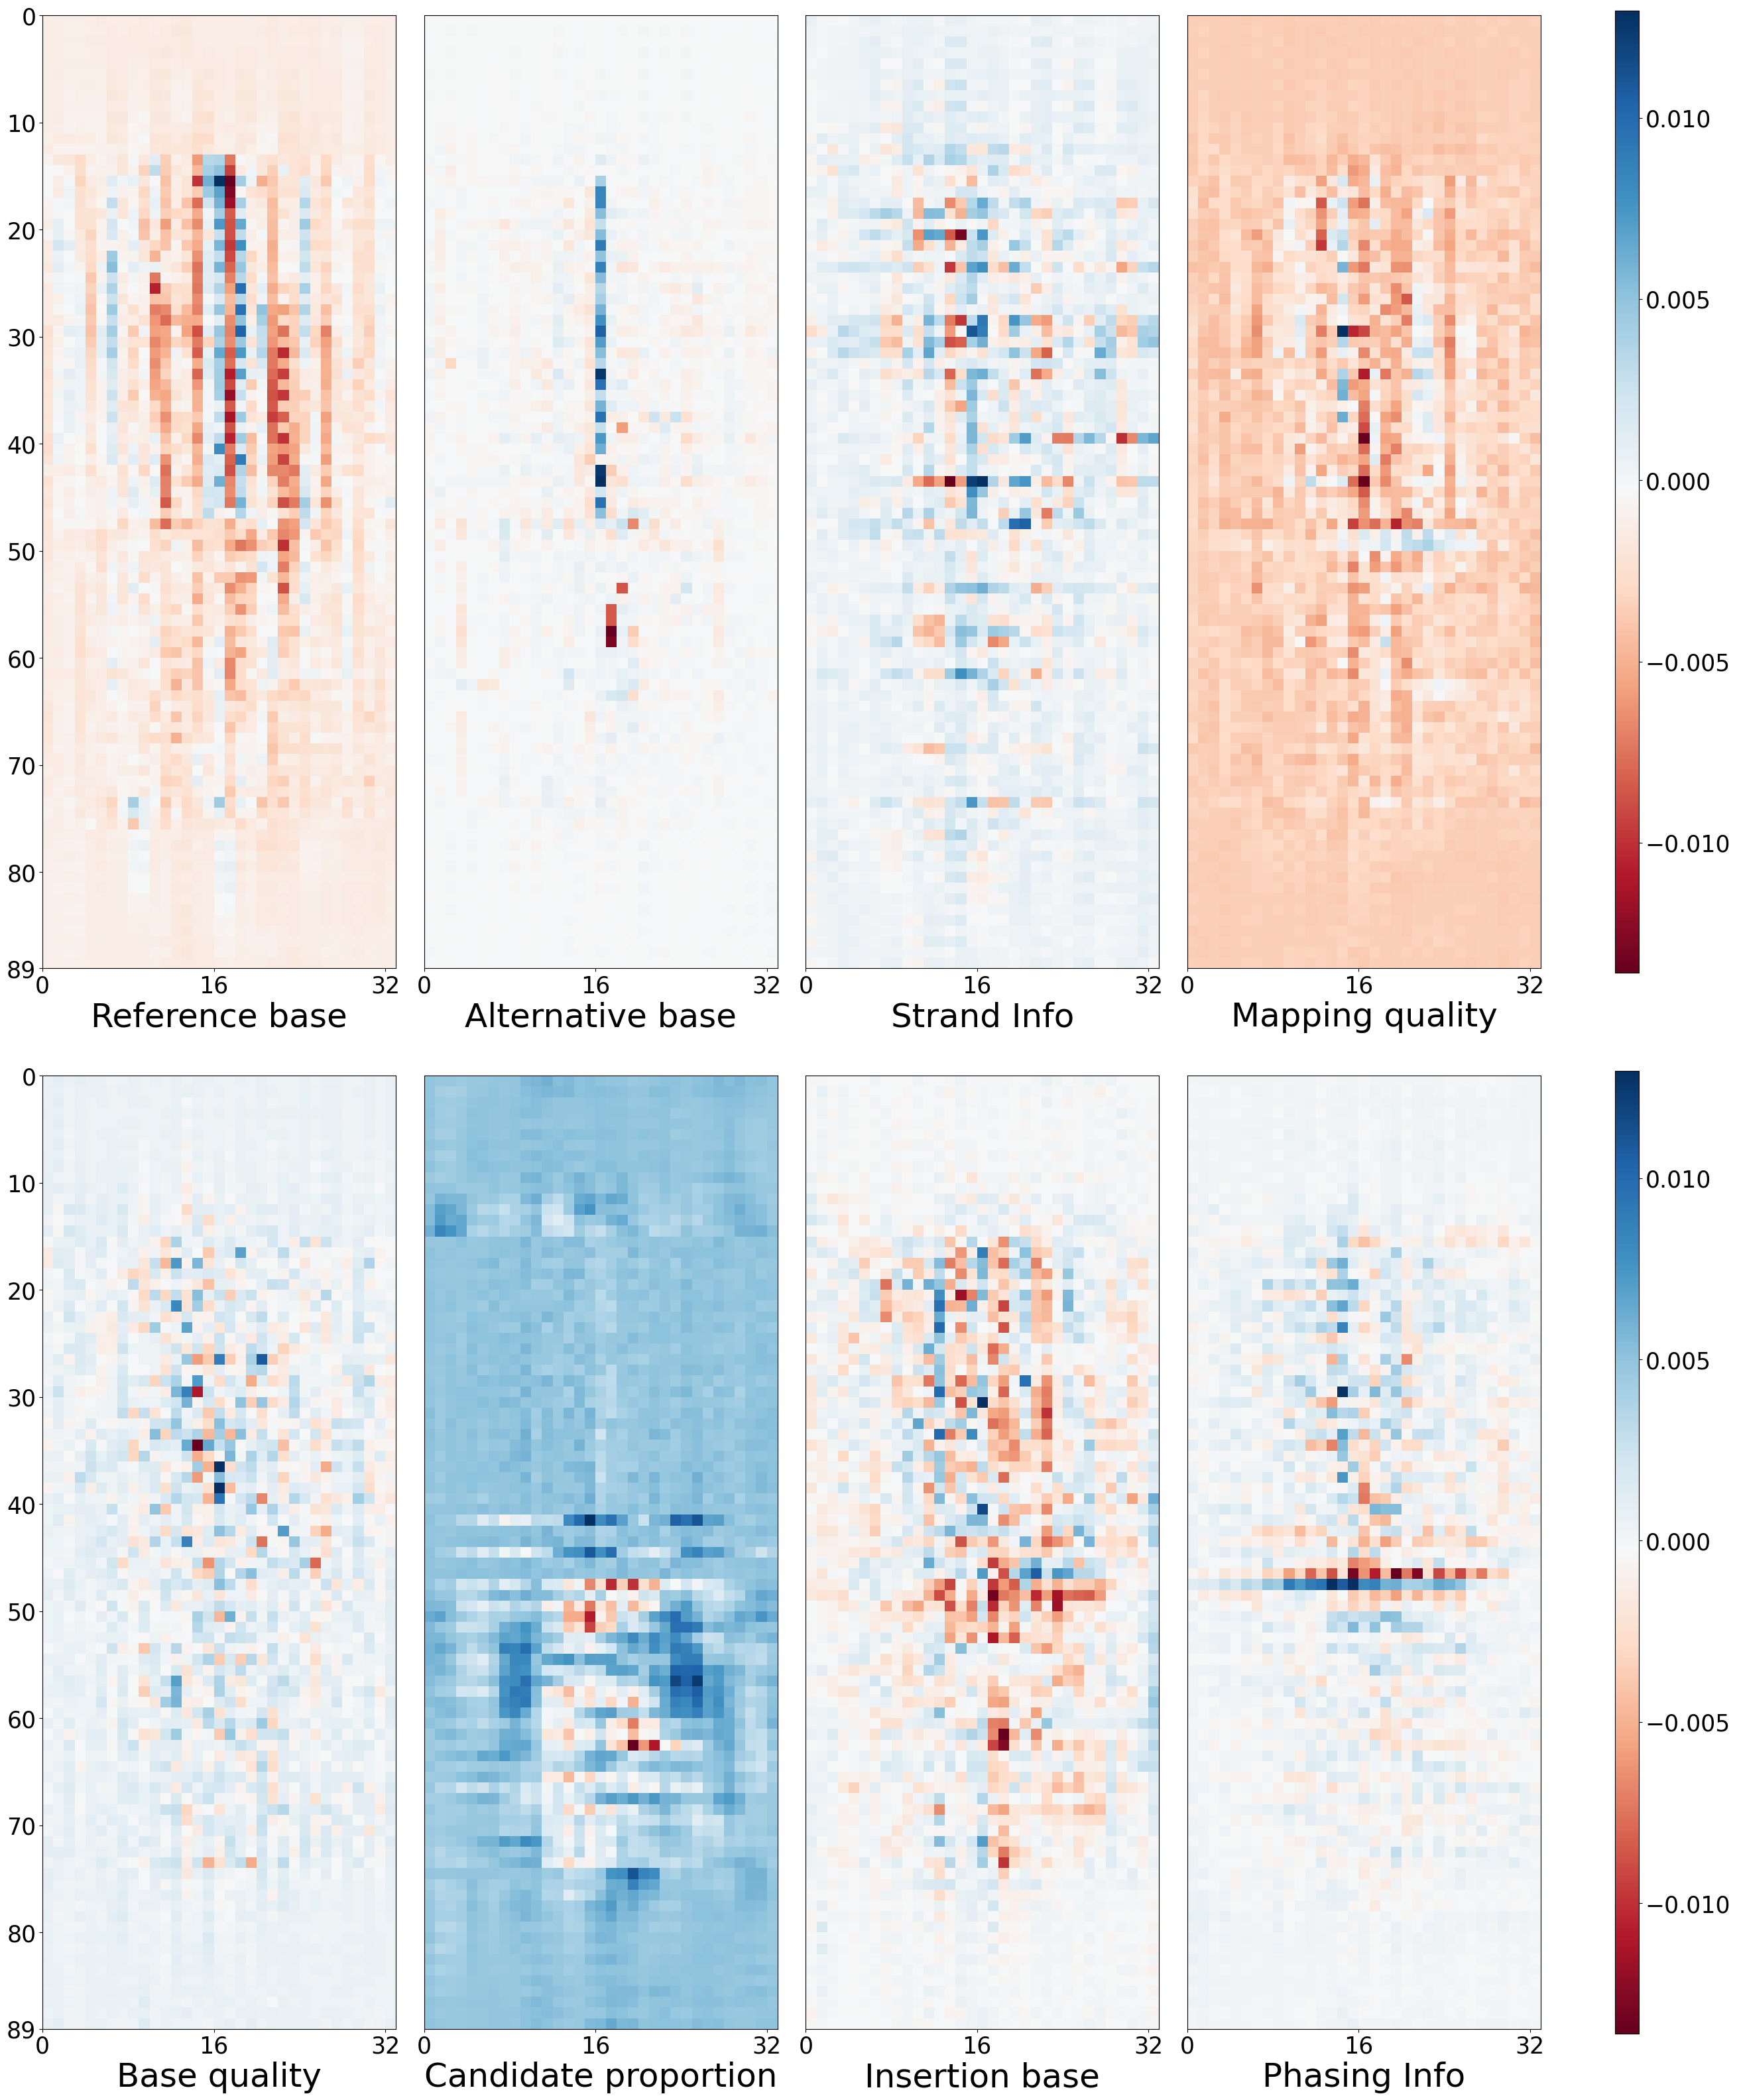

[INFO] Visualize input tensor of SNP position


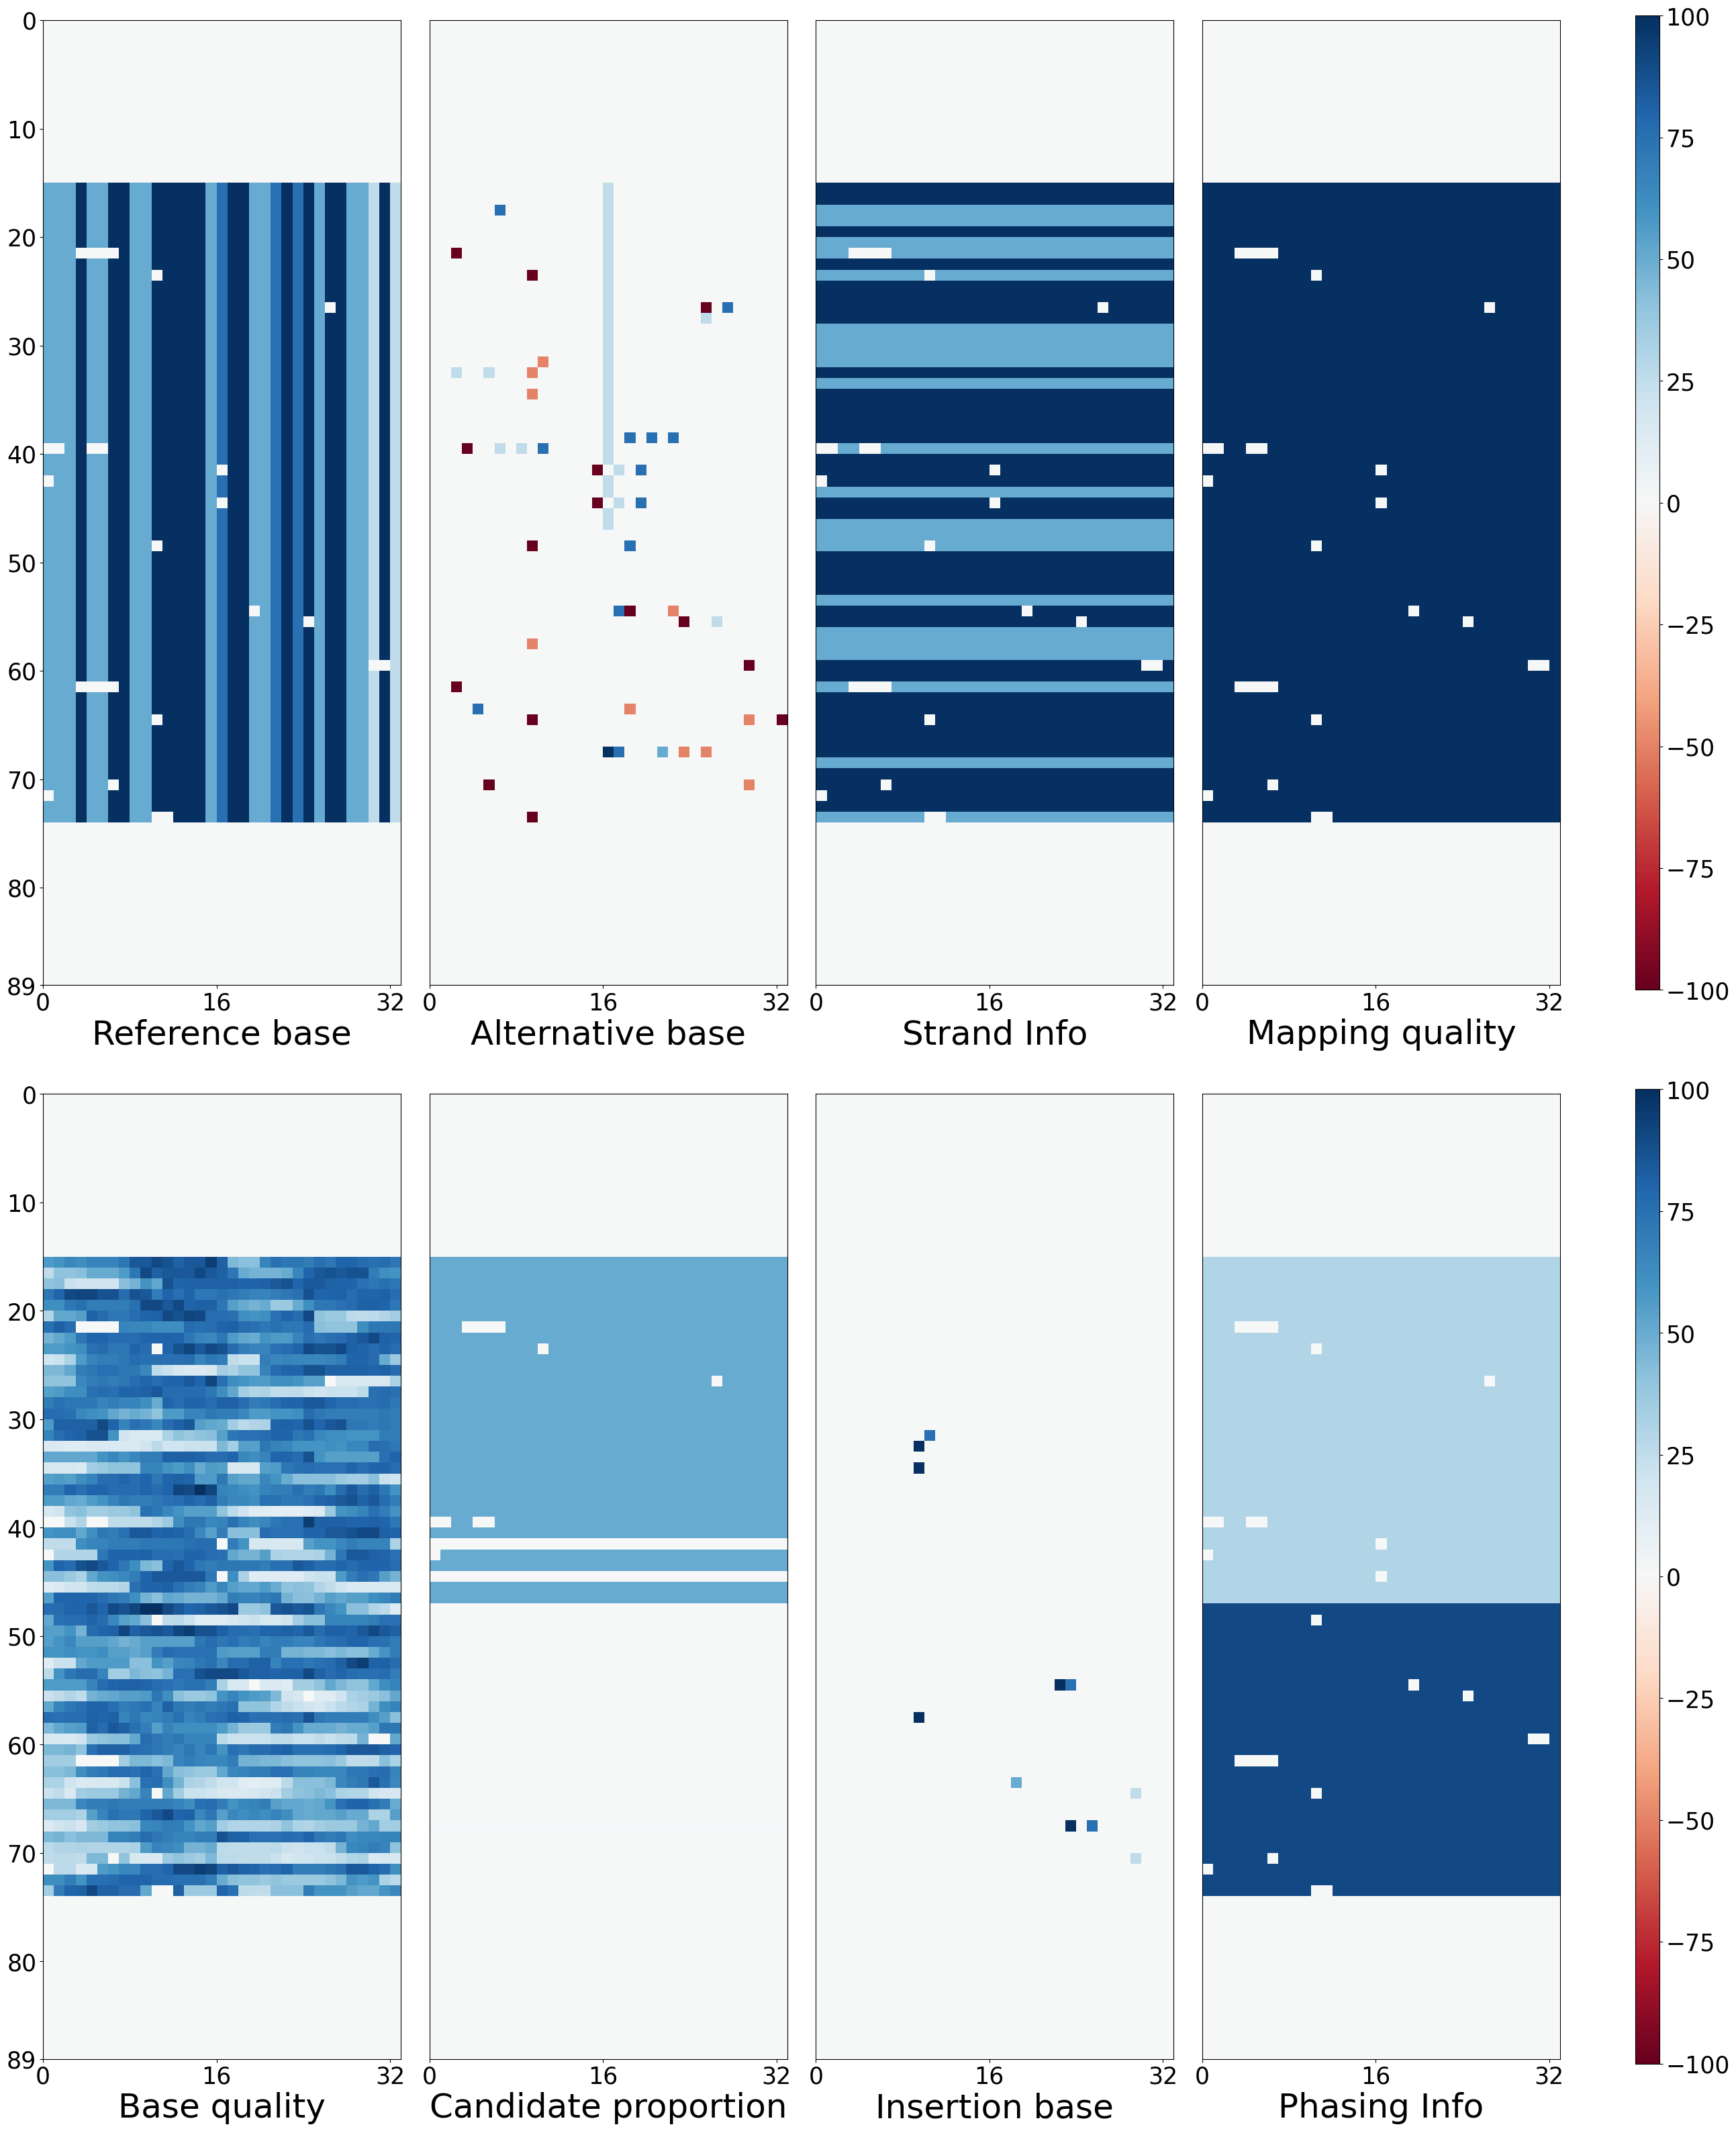

[INFO] Visualize guided backpropagation feature maps of Insertion position


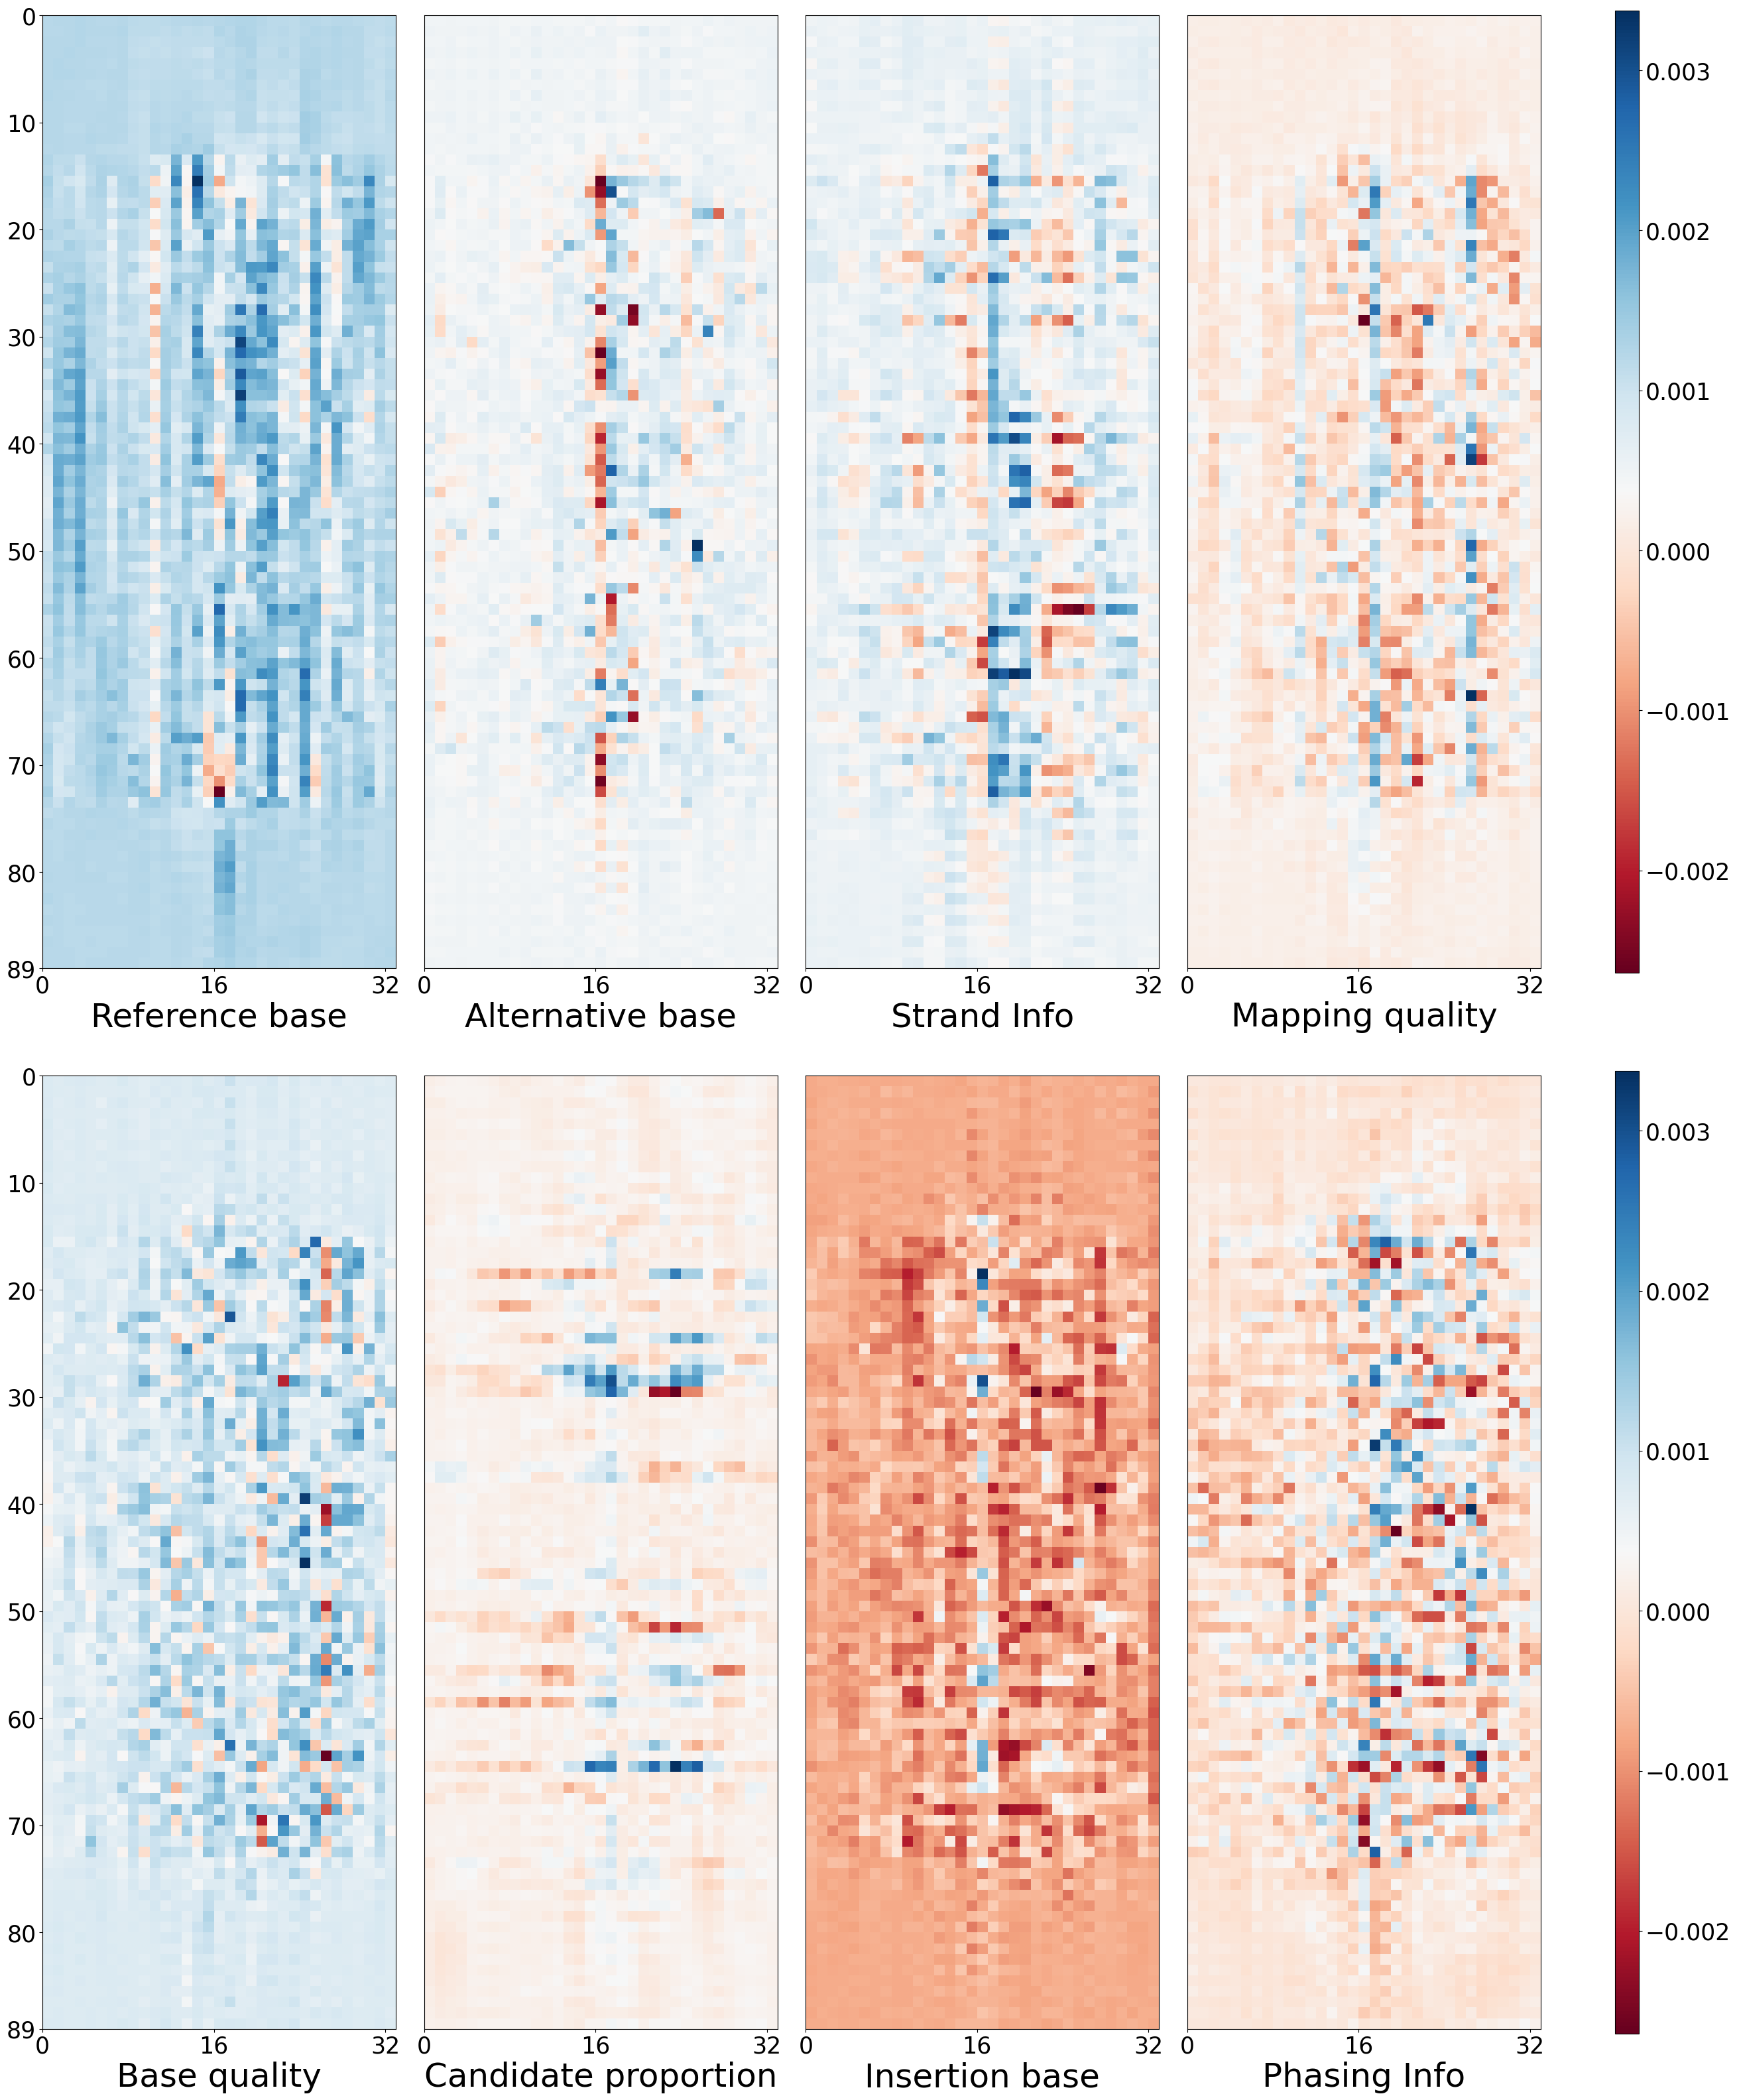

[INFO] Visualize input tensor of Insertion position


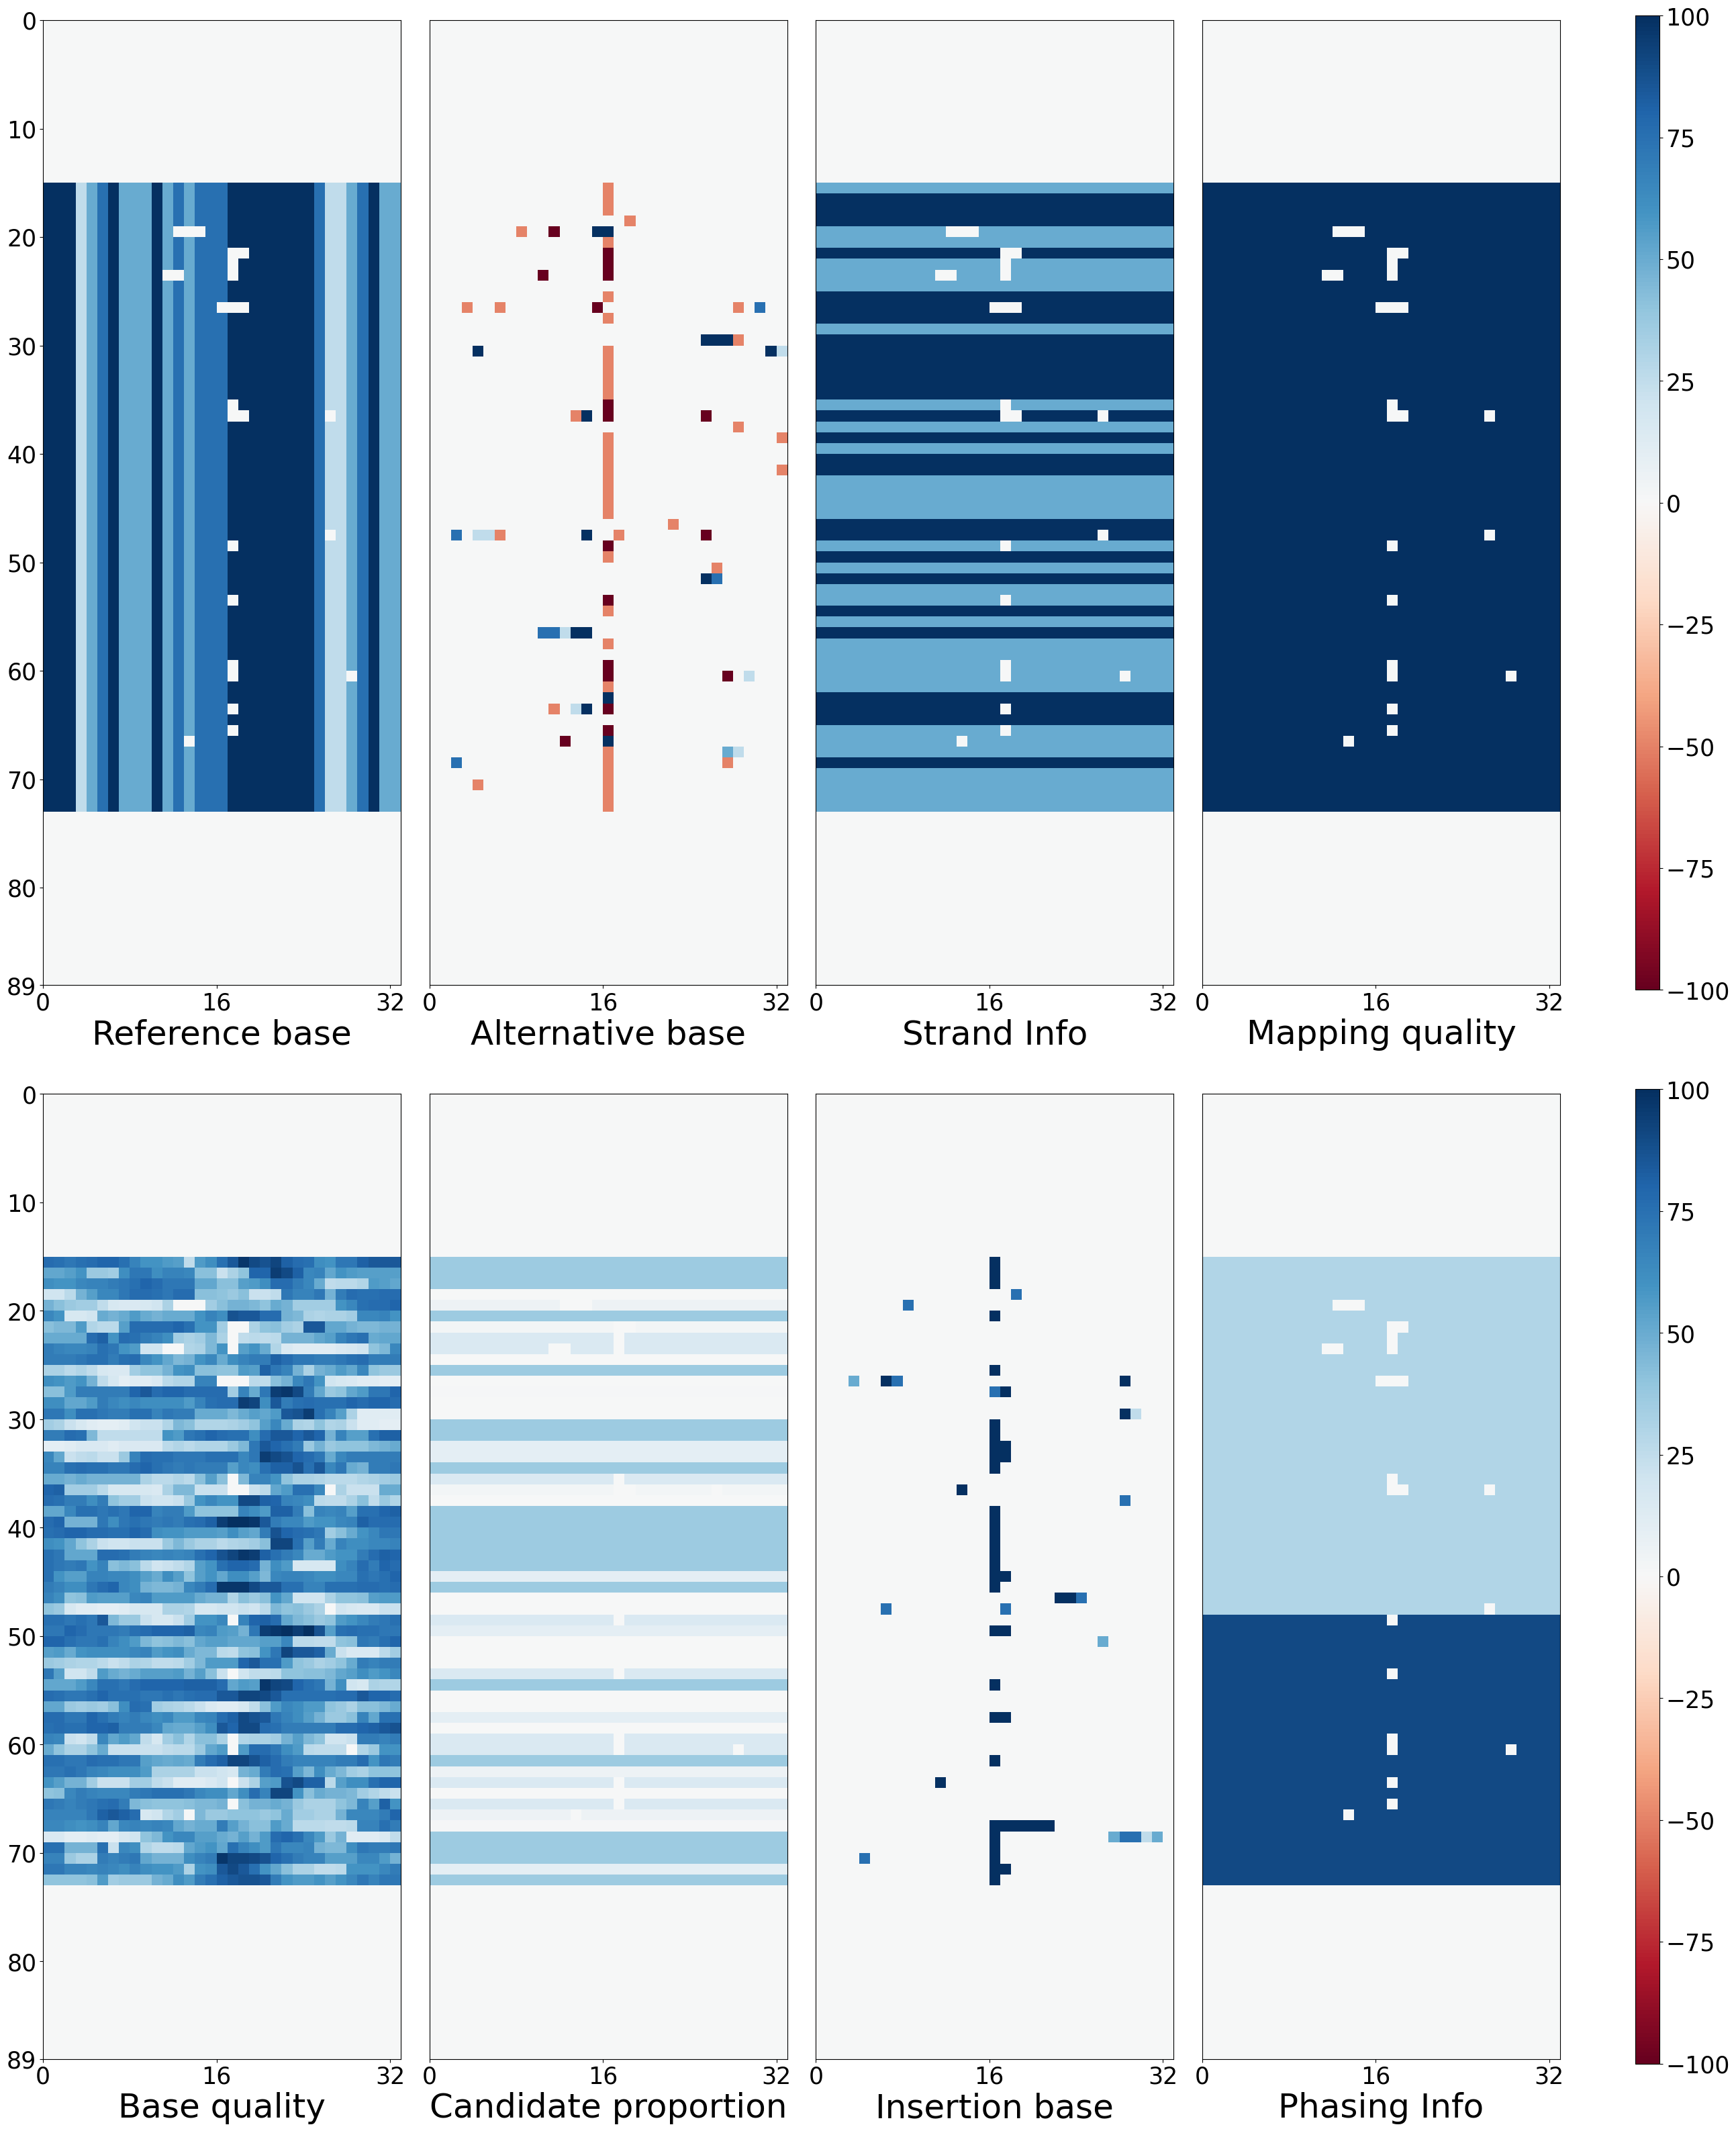

[INFO] Visualize guided backpropagation feature maps of Deletion position


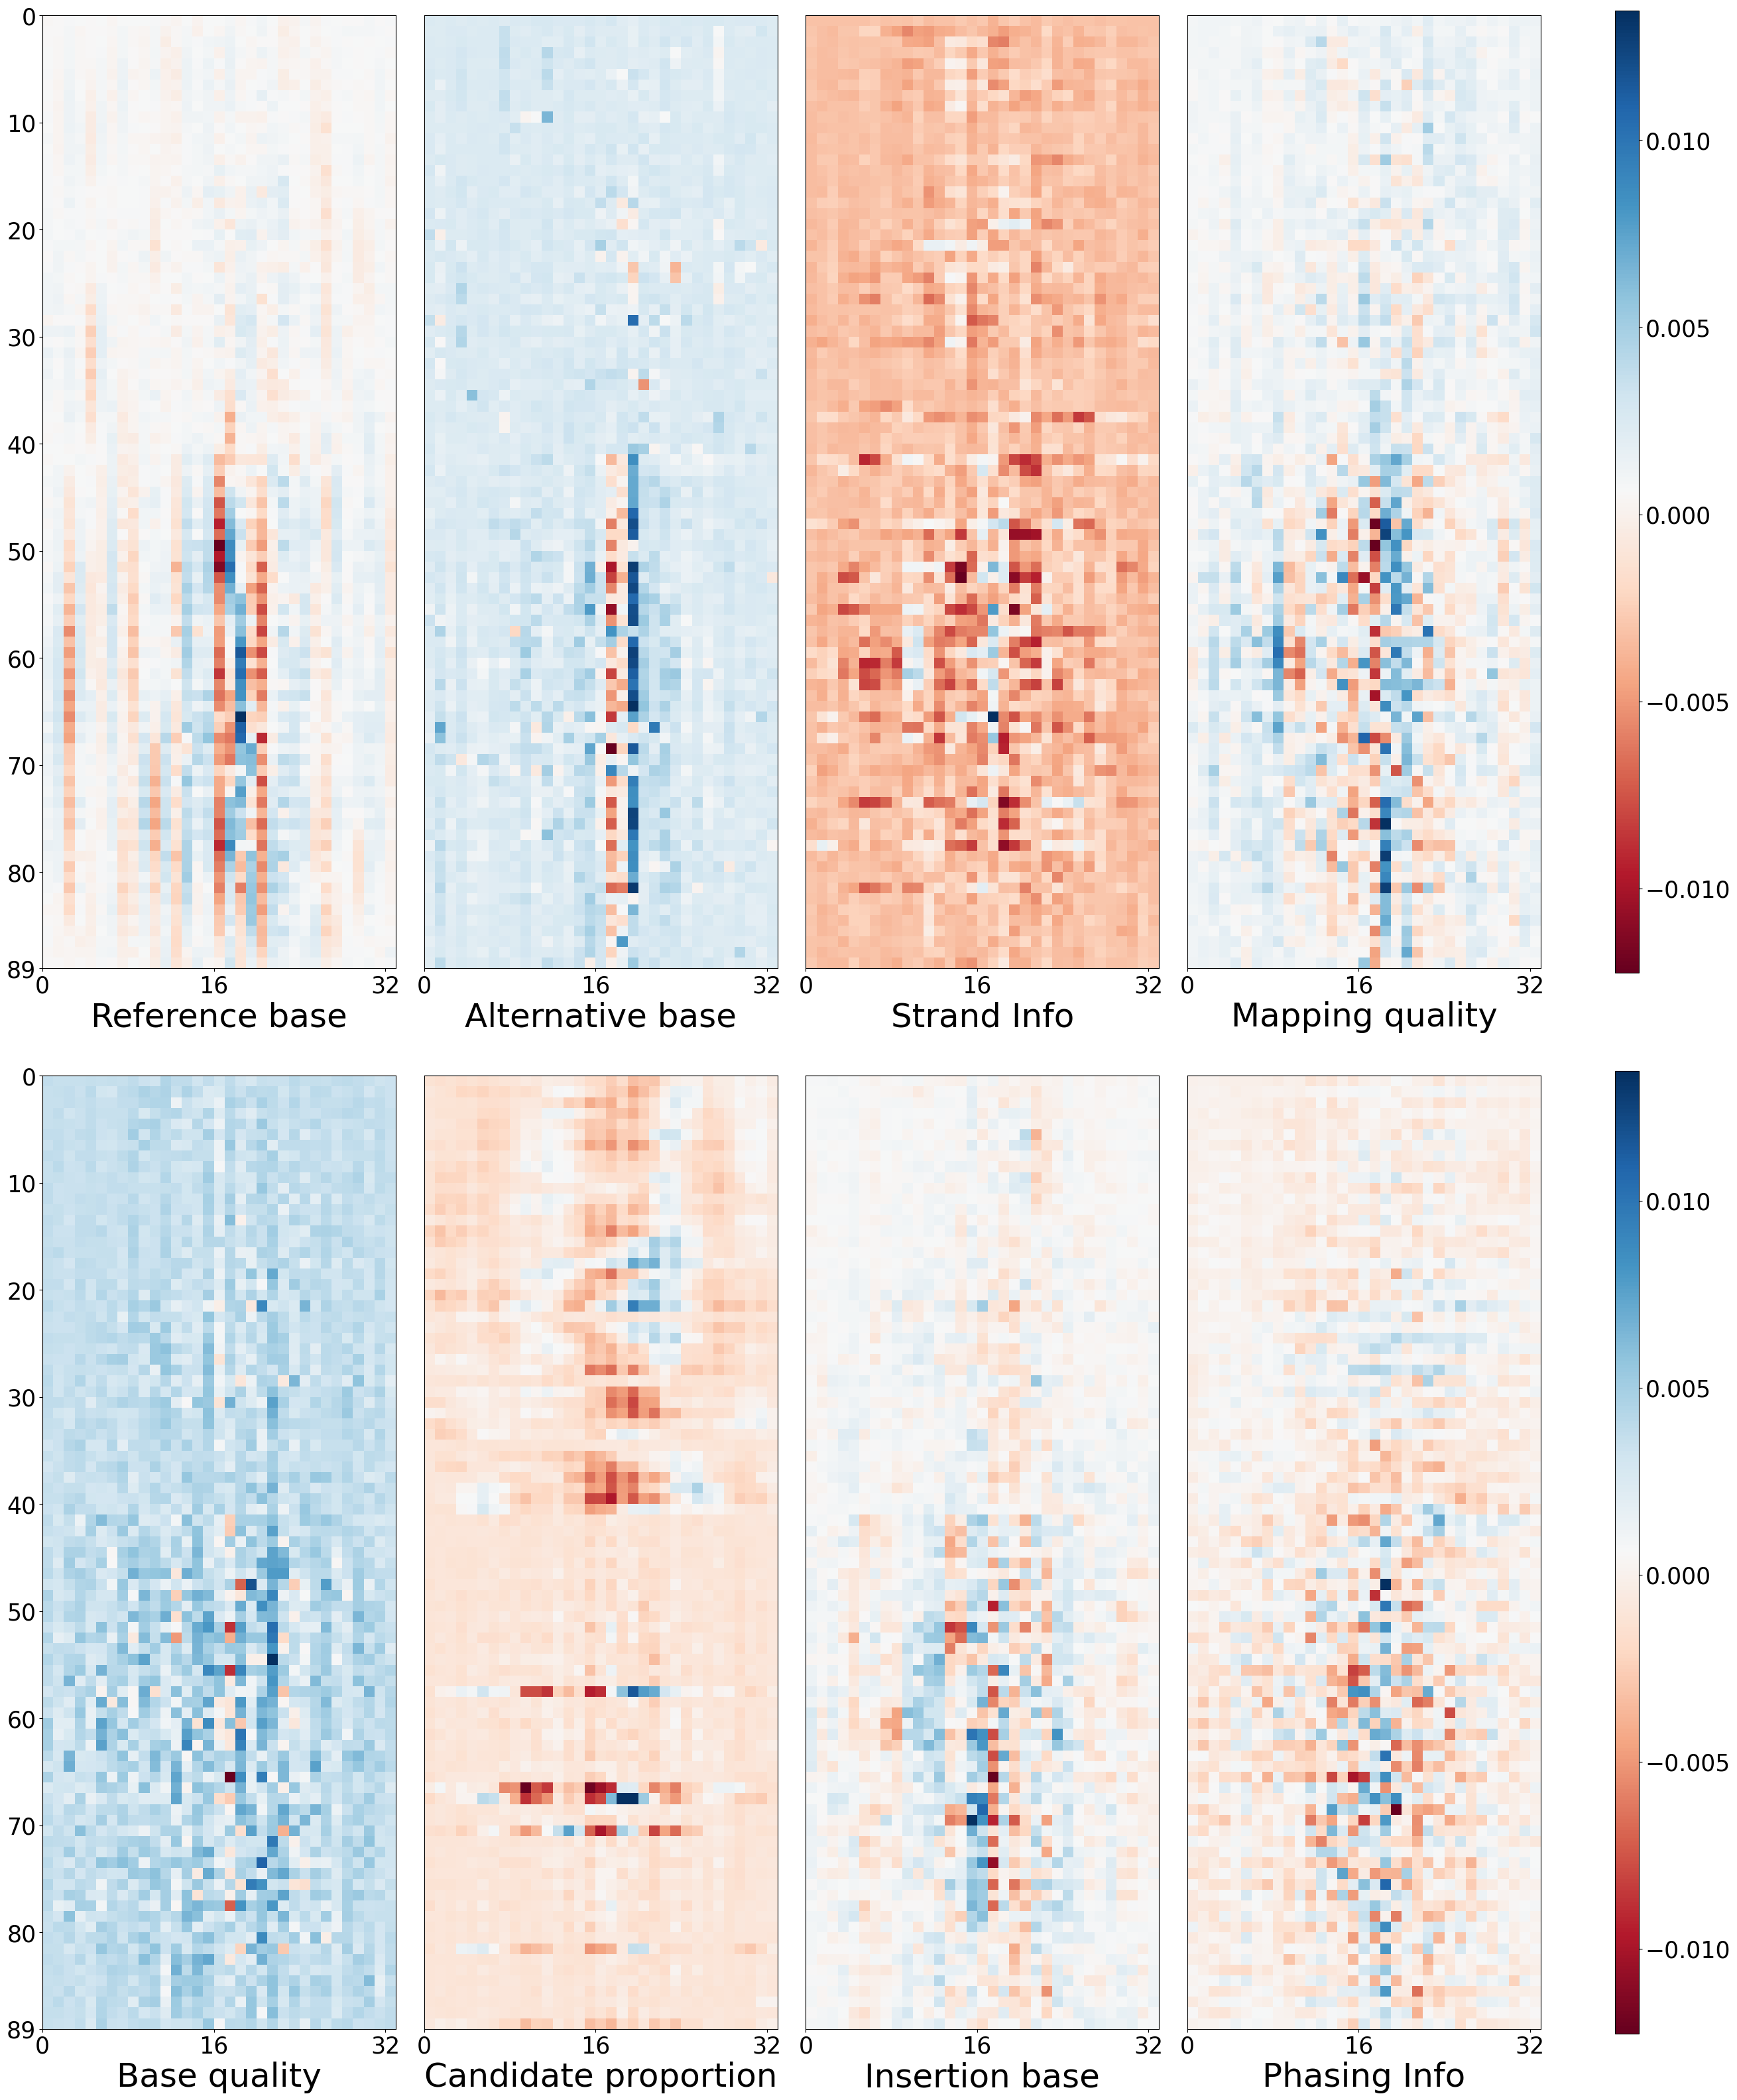

[INFO] Visualize input tensor of Deletion position


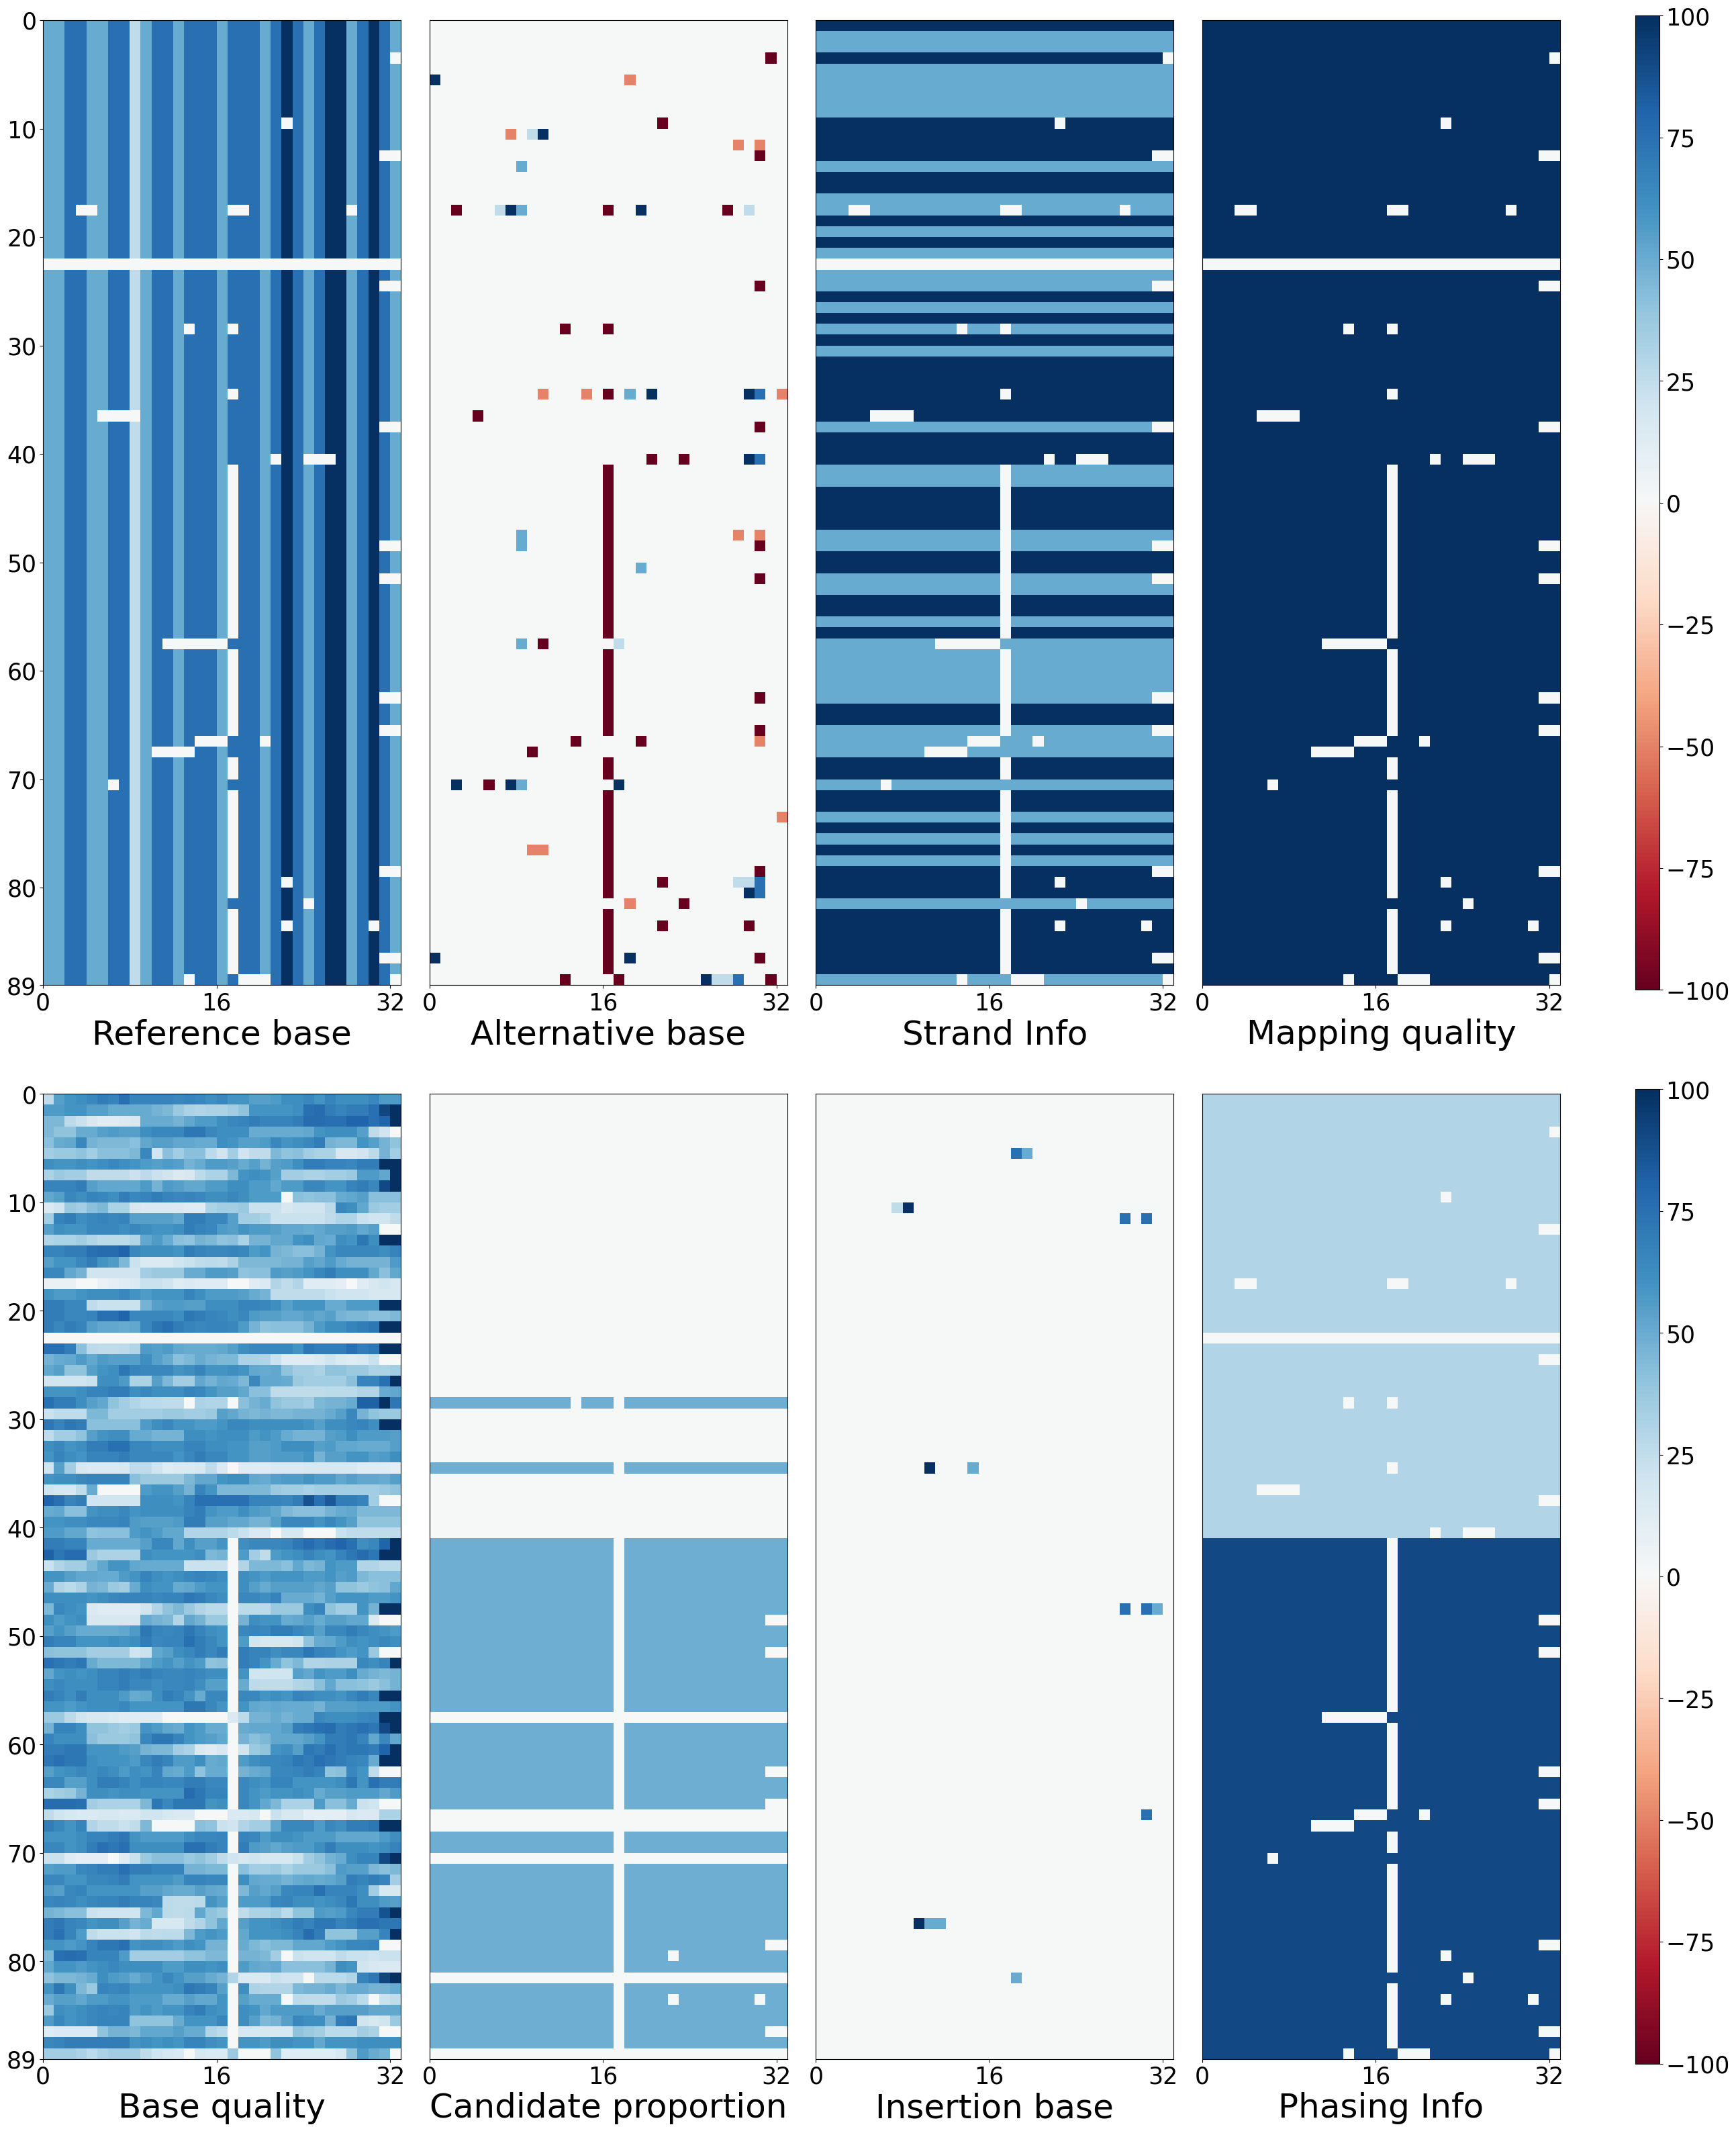

[INFO] Visualize guided backpropagation feature maps of Non-variant position


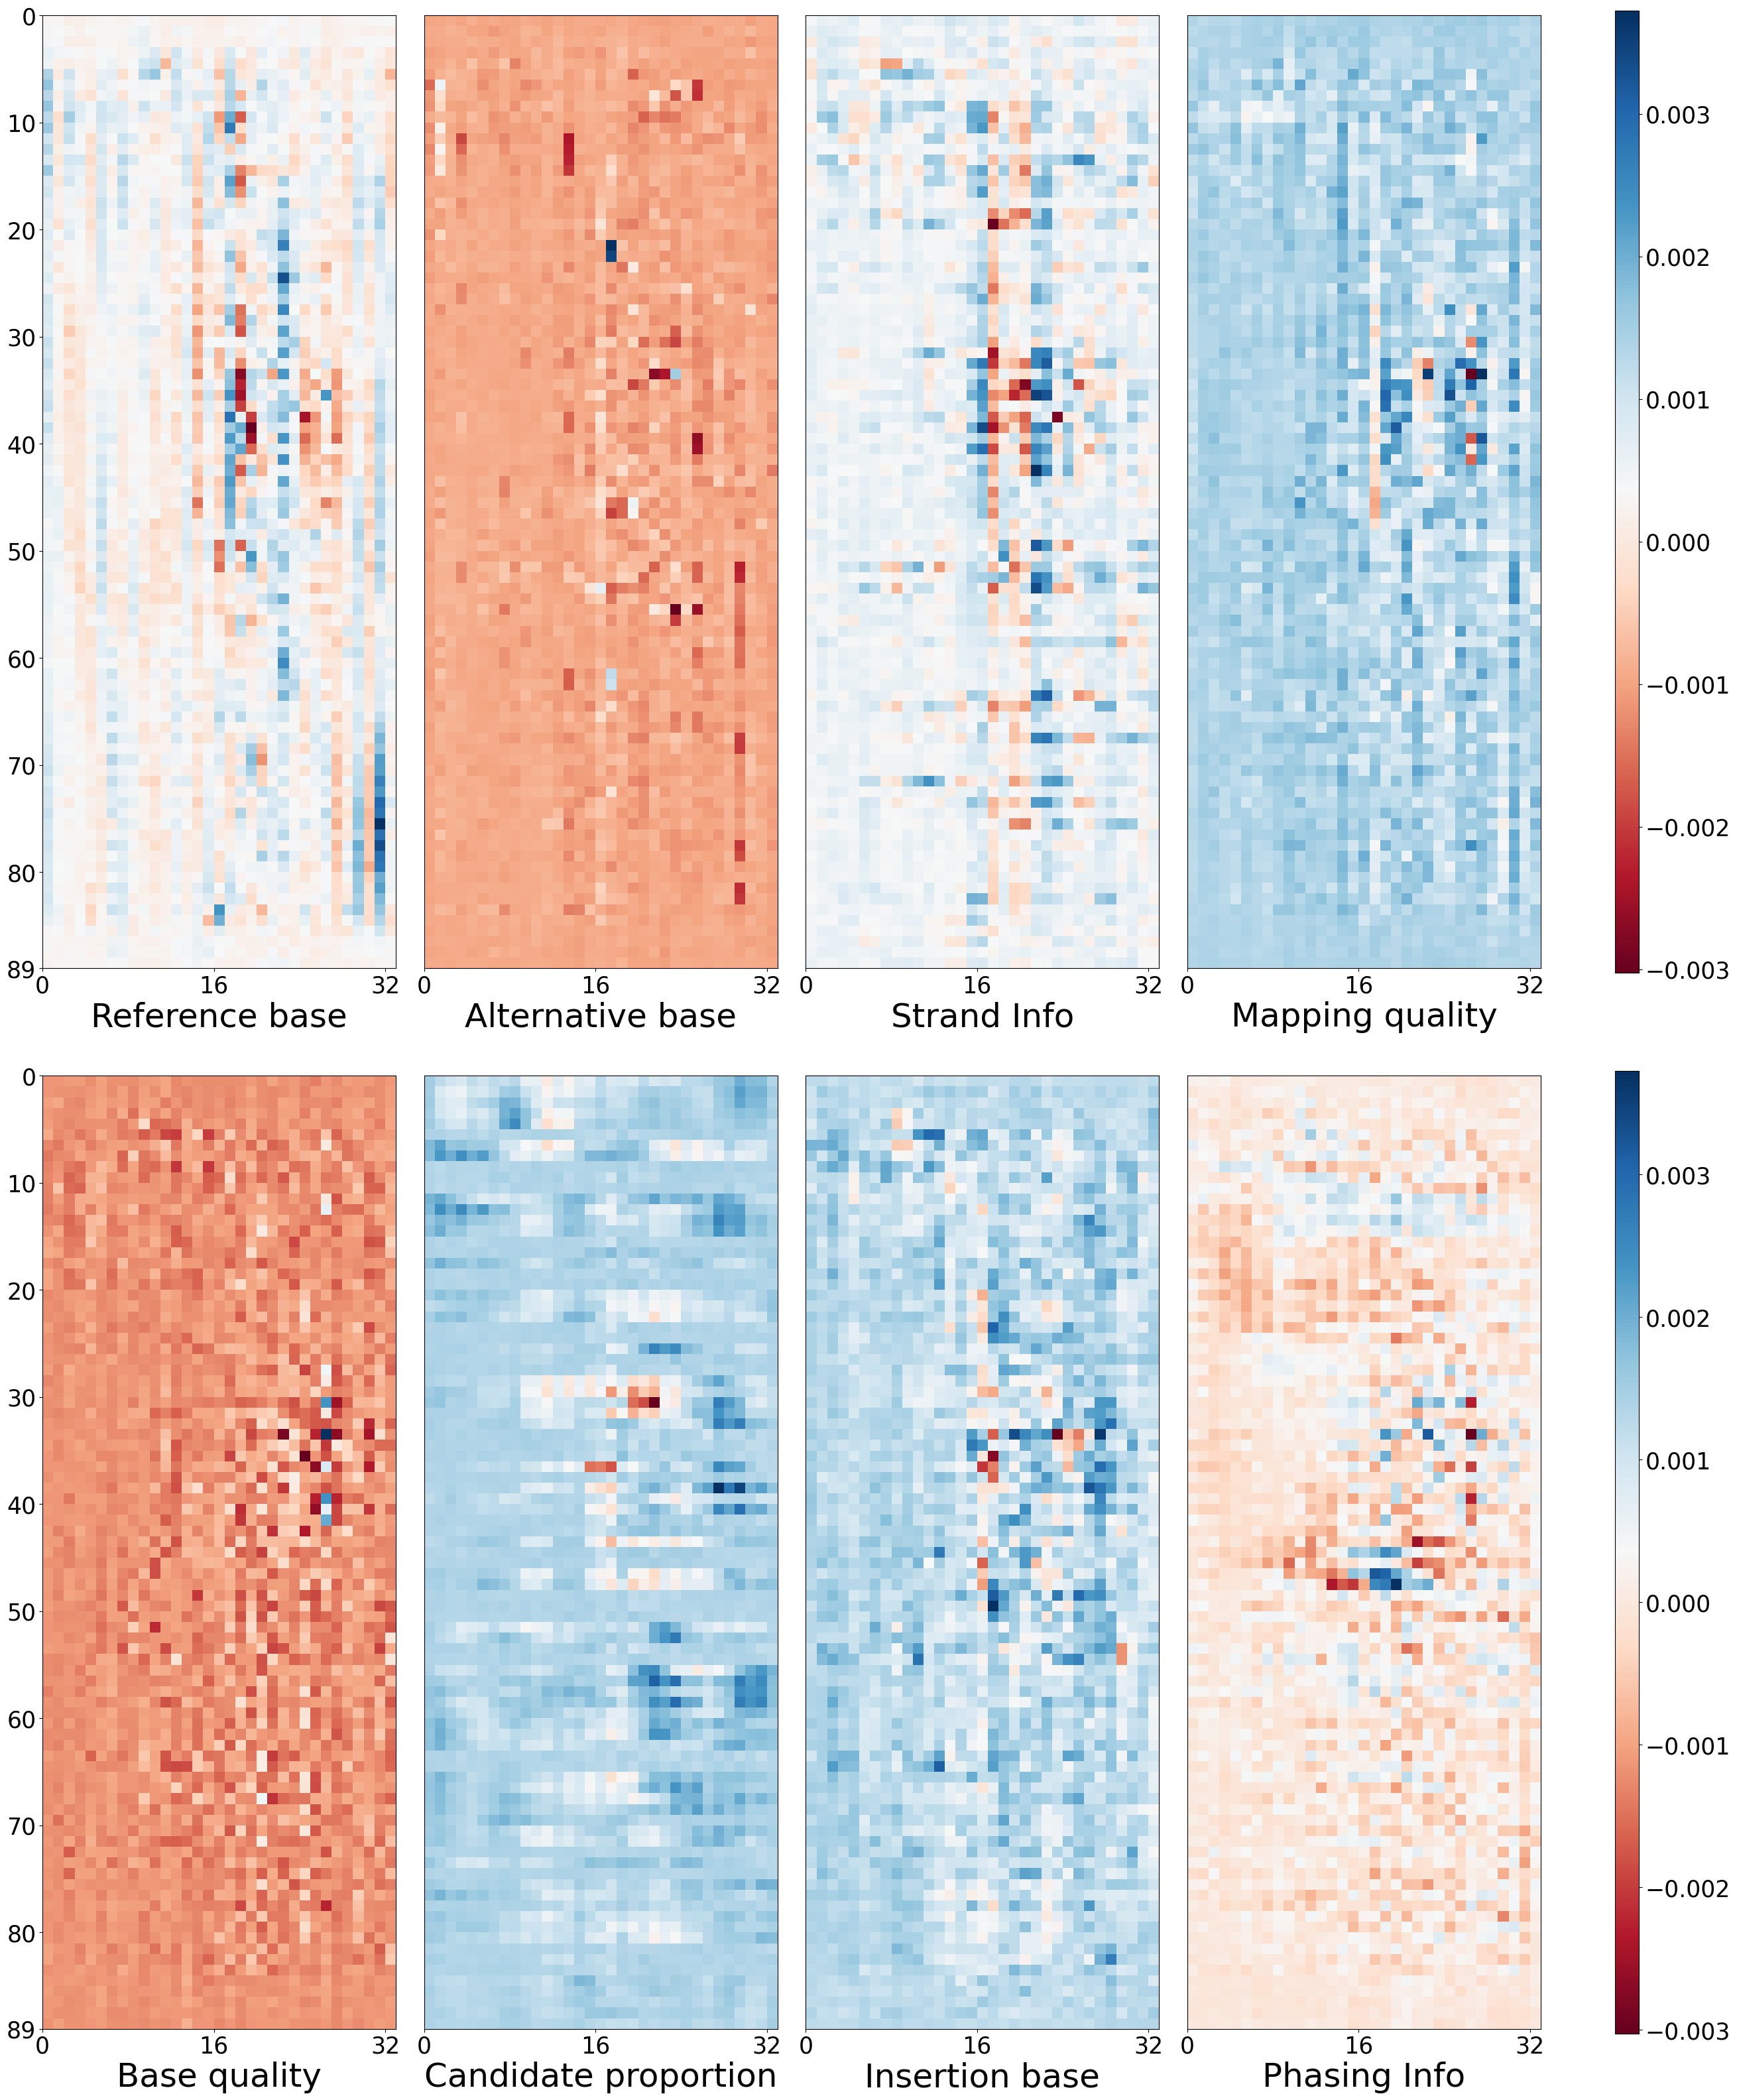

[INFO] Visualize input tensor of Non-variant position


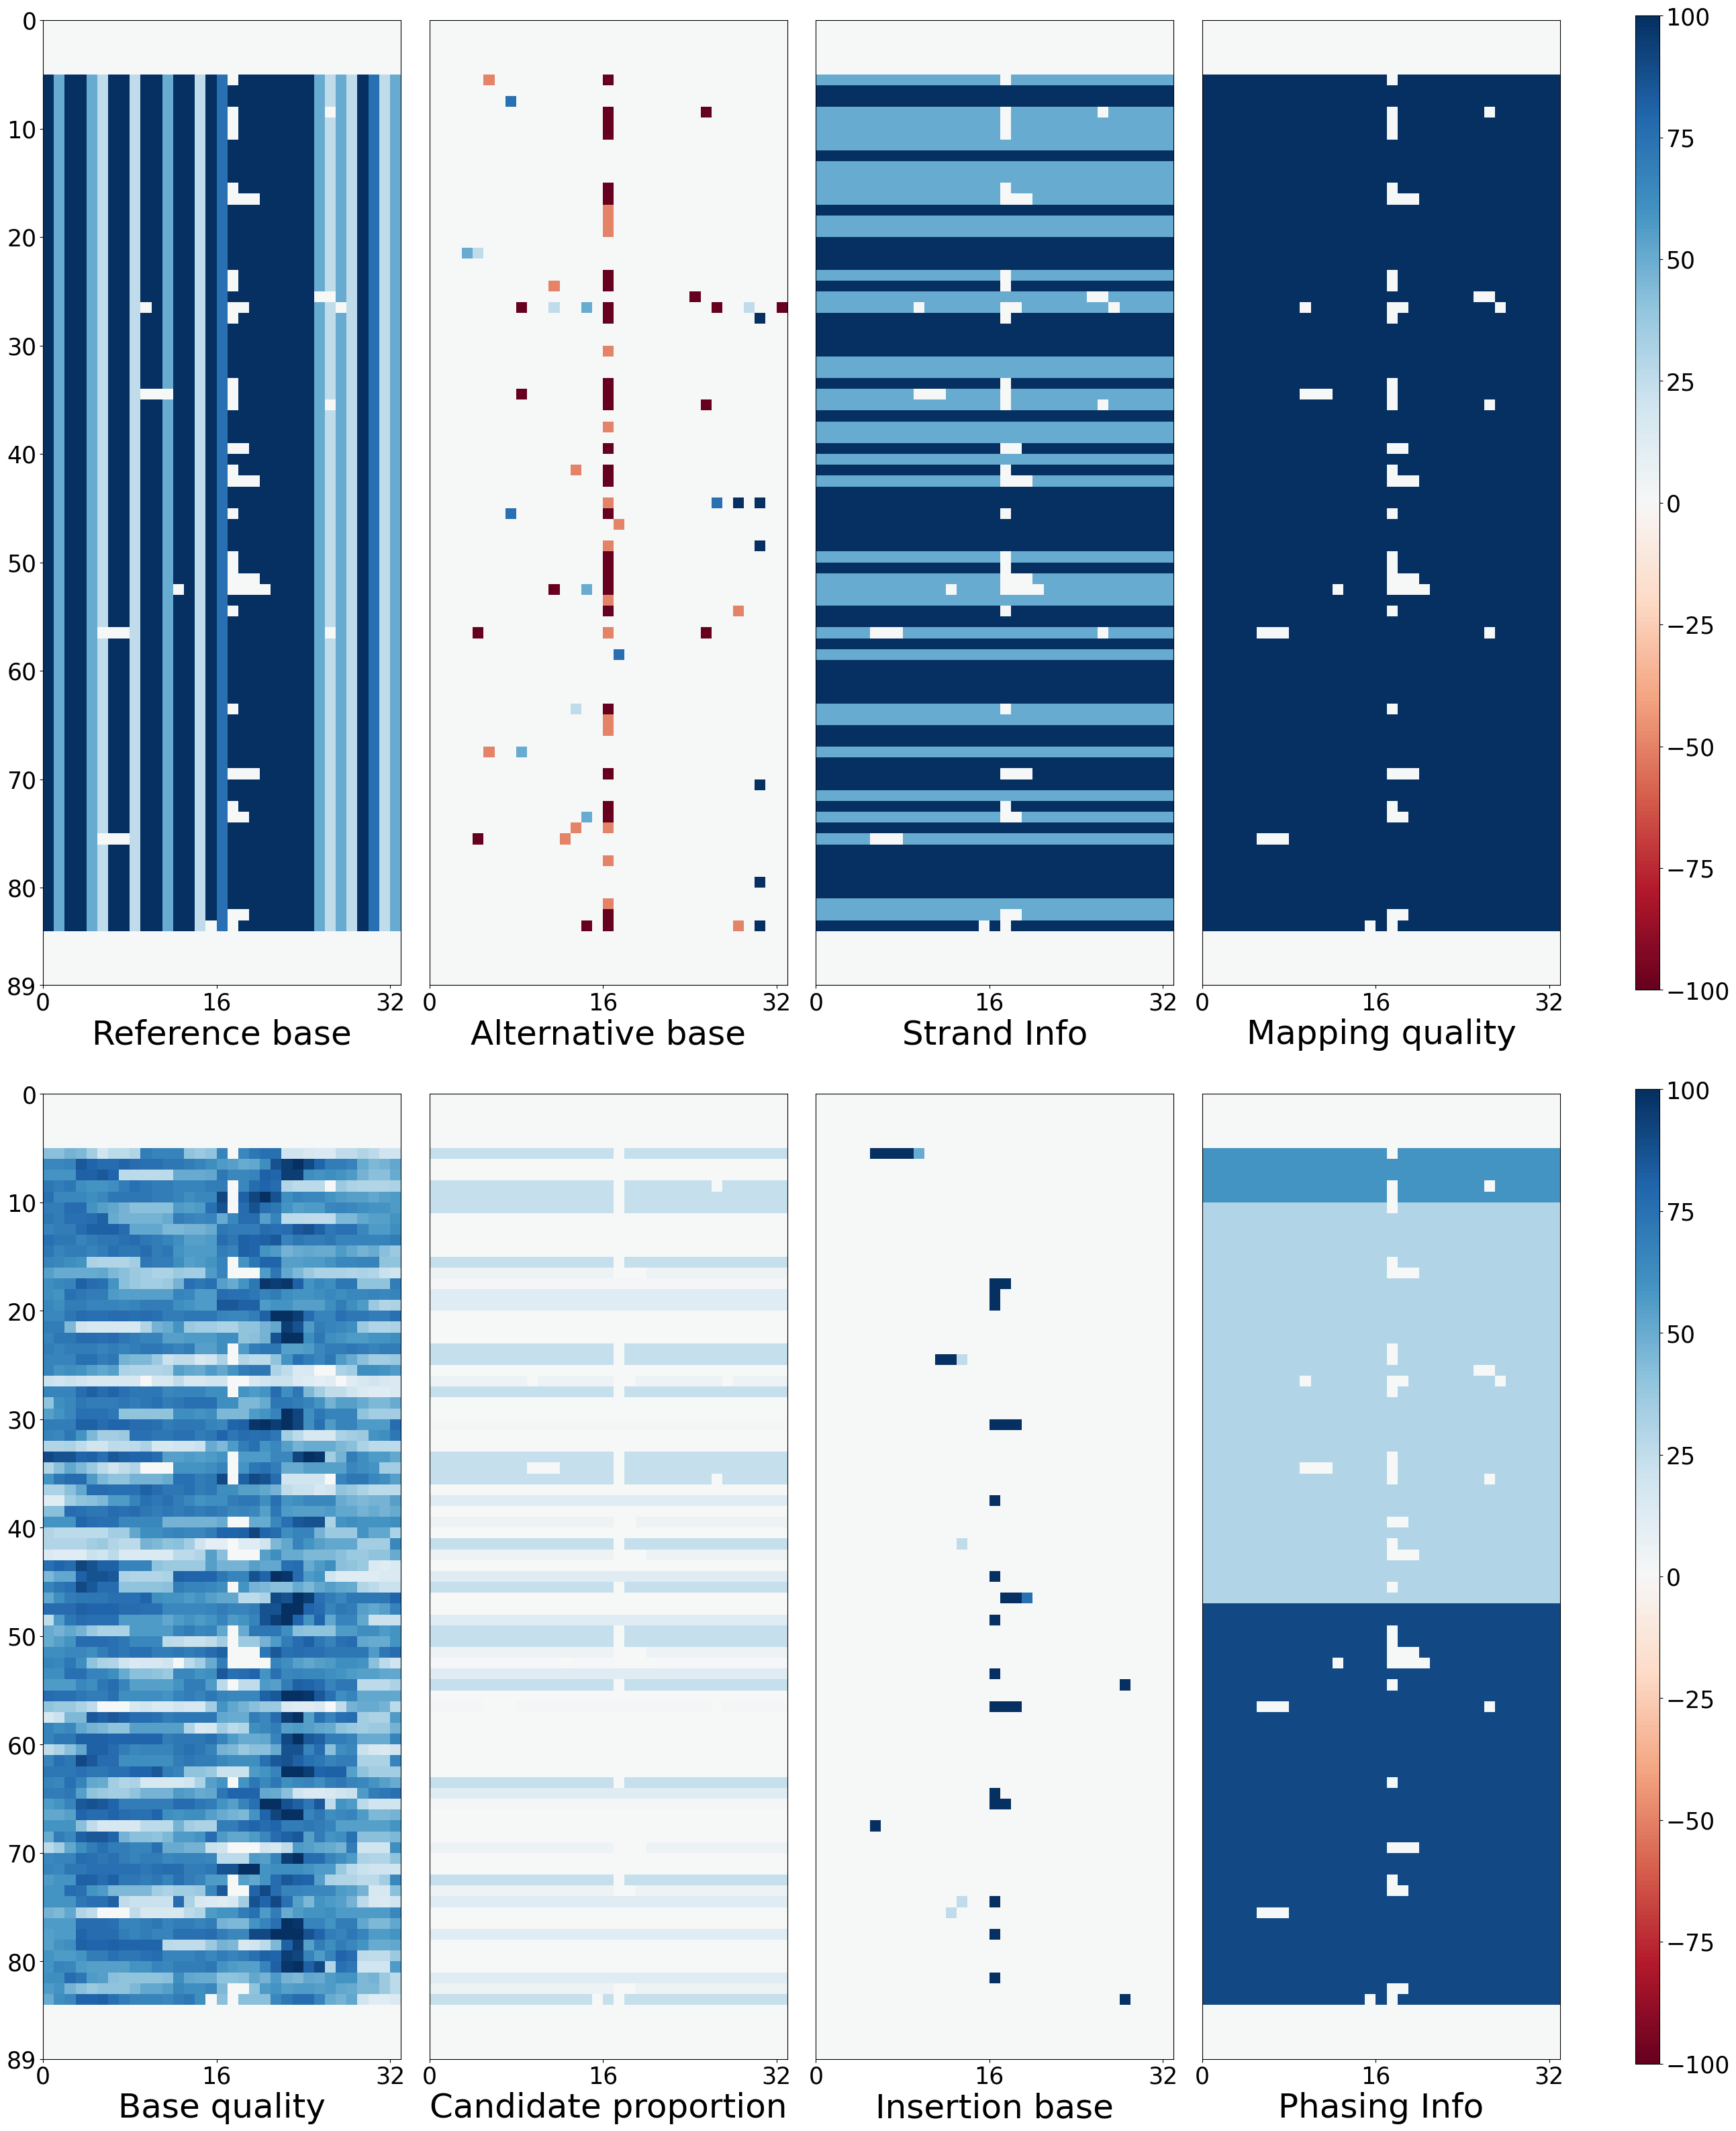

In [27]:
@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad


layer_dict = [layer for layer in m.layers[:] if hasattr(layer,'activation')]
for layer in layer_dict:
    if layer.activation == tf.keras.activations.relu:
        layer.activation = guidedRelu

label_list = ['Reference base', 'Alternative base', 'Strand Info', 'Mapping quality', \
              'Base quality', 'Candidate proportion', 'Insertion base','Phasing Info']

def vis_feature(input_tensor):
    if len(input_tensor.shape) == 3:
        input_tensor = input_tensor[np.newaxis, :,:,:]
    with tf.GradientTape() as tape:
        inputs = tf.cast(input_tensor, tf.float32)
        tape.watch(inputs)
        outputs = m(inputs)
    all_grads = tape.gradient(outputs,inputs)
    grads = all_grads[0]


    tensor_fa = grads
    nb_cols = 4
    fig = plt.figure(figsize=(36,40))
    gs = gridspec.GridSpec(2, nb_cols) 
    axes1 = [fig.add_subplot(gs[0, col], aspect="equal") for col in range(nb_cols)]
    axes2 = [fig.add_subplot(gs[1, col], aspect="equal") for col in range(nb_cols)]
    axes = [axes1, axes2]
    plt.xticks((0, 16, 32))
    for i in range(2):
        for col, ax in enumerate(axes[i]):
            idx = i*nb_cols+ col
            im = ax.pcolormesh(grads[:,:,idx], cmap=cm.RdBu,)
            y = list(range(0, 90, 10)) + [89]
            ax.set_yticks(y)
            ax.set_ylim(ax.get_ylim()[::-1])
            if col > 0:
                ax.yaxis.set_visible(False)
            ax.set_xlabel(label_list[idx], fontsize=36)
            ax.set_xticks((0, 16, 32))
            ax.xaxis.set_tick_params(labelsize=25)
            ax.yaxis.set_tick_params(labelsize=25)

    plt.subplots_adjust(hspace =0.08, wspace=0.08)
    cb = fig.colorbar(im, ax=axes1, pad=0.04, shrink=0.98, aspect=40)
    cb.ax.tick_params(labelsize=25)
    cb1 = fig.colorbar(im, ax=axes2, pad=0.04, shrink=0.98, aspect=40)
    cb1.ax.tick_params(labelsize=25)
    plt.show()
    
def vis_input(input_tensor):

    nb_cols = 4
    fig = plt.figure(figsize=(36,40))
    gs = gridspec.GridSpec(2, nb_cols) 
    axes1 = [fig.add_subplot(gs[0, col], aspect="equal") for col in range(nb_cols)]
    axes2 = [fig.add_subplot(gs[1, col], aspect="equal") for col in range(nb_cols)]
    axes = [axes1, axes2]
    plt.xticks((0, 16, 32))
    for i in range(2):
        for col, ax in enumerate(axes[i]):
            idx = i*nb_cols+ col
            im = ax.pcolormesh(input_tensor[:,:,idx], cmap=cm.RdBu,vmin=-100, vmax=100)
            y = list(range(0, 90, 10)) + [89]
            ax.set_yticks(y)
            ax.set_ylim(ax.get_ylim()[::-1])
            if col > 0:
                ax.yaxis.set_visible(False)
            ax.set_xlabel(label_list[idx], fontsize=36)
            ax.set_xticks((0, 16, 32))
            ax.xaxis.set_tick_params(labelsize=25)
            ax.yaxis.set_tick_params(labelsize=25)

    plt.subplots_adjust(hspace =0.08, wspace=0.08)
    cb = fig.colorbar(im, ax=axes1, pad=0.04, shrink=0.98, aspect=40)
    cb.ax.tick_params(labelsize=25)
    cb1 = fig.colorbar(im, ax=axes2, pad=0.04, shrink=0.98, aspect=40)
    cb1.ax.tick_params(labelsize=25)
    plt.show()

tensors = np.load(os.path.join(current_path, "input_matrix.npy"))
variant_type = ["SNP", 'Insertion', 'Deletion', 'Non-variant']
for idx in range(len(tensors)):
    print("[INFO] Visualize guided backpropagation feature maps of {} position".format(variant_type[idx]))
    vis_feature(tenosrs[idx])
    print("[INFO] Visualize input tensor of {} position".format(variant_type[idx]))
    vis_input(tenosrs[idx])